In [85]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, TFBertModel, TFAutoModelForSequenceClassification
from datasets import Dataset, concatenate_datasets, DatasetDict, load_metric
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense



In [2]:
cwd = os.getcwd()
datapath = os.path.join(cwd, 'dataset')
addition_data_path = os.path.join(datapath, 'archive', 'Summarized')

addition_data_ = os.listdir(addition_data_path)
addition_data_

['dataset_cnn_summarized.xlsx',
 'dataset_kompas_summarized.xlsx',
 'dataset_tempo_summarized.xlsx',
 'dataset_turnbackhoax_summarized.xlsx']

In [3]:
addition_data = {"_".join(data.split('_')[0:2]) : pd.read_excel(os.path.join(addition_data_path, data)) for data in addition_data_}
addition_data['dataset_cnn'].head()

,index,title,raw timestamp,original,tags,author,url,cleaned,label,timestamp,cleaned token length,summarized
0,0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,"Selasa, 21 Feb 2023 21:22 WIB","Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",anies baswedan;pengajian;pilpres 2024;badan ko...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,2023-02-21 21:22:00,401,Mantan Gubernur DKI Jakarta Anies Baswedan men...
1,1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,"Selasa, 21 Feb 2023 20:46 WIB","Medan, CNN Indonesia -- Gubernur Sumatera Utar...",edy rahmayadi;pemilu 2024;pilkada 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,2023-02-21 20:46:00,410,Gubernur Sumatera Utara Edy Rahmayadi membuka ...
2,2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,"Selasa, 21 Feb 2023 20:33 WIB","Jakarta, CNN Indonesia -- Partai Kebangkitan B...",ida fauziyah;pkb;pemilu 2024;pileg 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,2023-02-21 20:33:00,285,PKB bakal mengusung Menteri Ketenagakerjaan Id...
3,3,Gede Pasek Doakan AHY Jadi Capres atau Cawapres,"Selasa, 21 Feb 2023 19:58 WIB","Jakarta, CNN Indonesia -- Ketua Umum Partai Ke...",gede pasek suardika;ahy;pilpres 2024;pemilu 20...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,2023-02-21 19:58:00,279,Ketua Umum Partai Kebangkitan Nusantara (PKN) ...
4,4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,"Selasa, 21 Feb 2023 18:56 WIB","Jakarta, CNN Indonesia -- Dewan Pimpinan Pusat...",anas urbaningrum;pkn;pemilu 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,2023-02-21 18:56:00,305,Dewan Pimpinan Pusat PKN menyiapkan jabatan kh...


In [4]:
addition_data.keys()

dict_keys(['dataset_cnn', 'dataset_kompas', 'dataset_tempo', 'dataset_turnbackhoax'])

In [5]:
addition_data['dataset_cnn'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9630 entries, 0 to 9629
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 9630 non-null   int64         
 1   title                 9630 non-null   object        
 2   raw timestamp         9630 non-null   object        
 3   original              9630 non-null   object        
 4   tags                  9627 non-null   object        
 5   author                9630 non-null   object        
 6   url                   9630 non-null   object        
 7   cleaned               9630 non-null   object        
 8   label                 9630 non-null   int64         
 9   timestamp             9630 non-null   datetime64[ns]
 10  cleaned token length  9630 non-null   int64         
 11  summarized            9630 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 902.9+ KB


In [6]:
addition_data['dataset_kompas'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4729 entries, 0 to 4728
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 4729 non-null   int64         
 1   title                 4729 non-null   object        
 2   raw timestamp         4729 non-null   object        
 3   original              4723 non-null   object        
 4   tags                  4592 non-null   object        
 5   author                4413 non-null   object        
 6   url                   4729 non-null   object        
 7   cleaned               4723 non-null   object        
 8   label                 4729 non-null   int64         
 9   timestamp             4729 non-null   datetime64[ns]
 10  cleaned token length  4729 non-null   int64         
 11  summarized            4547 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 443.5+ KB


In [7]:
addition_data['dataset_tempo'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 6592 non-null   int64         
 1   title                 6592 non-null   object        
 2   raw timestamp         6592 non-null   object        
 3   original              6592 non-null   object        
 4   tags                  6591 non-null   object        
 5   author                6592 non-null   object        
 6   url                   6592 non-null   object        
 7   cleaned               6592 non-null   object        
 8   label                 6592 non-null   int64         
 9   timestamp             6592 non-null   datetime64[ns]
 10  cleaned token length  6592 non-null   int64         
 11  summarized            6592 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 618.1+ KB


In [8]:
addition_data['dataset_turnbackhoax'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10381 entries, 0 to 10380
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 10381 non-null  int64         
 1   title                 10381 non-null  object        
 2   raw timestamp         10381 non-null  object        
 3   original              10381 non-null  object        
 4   tags                  10381 non-null  object        
 5   author                10381 non-null  object        
 6   url                   10381 non-null  object        
 7   politik               10381 non-null  int64         
 8   raw narasi            10381 non-null  object        
 9   cleaned               6502 non-null   object        
 10  label                 10381 non-null  int64         
 11  timestamp             10381 non-null  datetime64[ns]
 12  cleaned token length  10381 non-null  int64         
 13  summarized      

In [9]:
def space_to_punct(text):
    for punct in string.punctuation:
        text = text.replace(punct, f' {punct} ')
        
    text = re.sub(' +', ' ', text)
    return text

In [10]:
for data in addition_data:
    addition_data[data]['cleaned'] = addition_data[data]['cleaned'][addition_data[data]['cleaned'].isna() == False]
    addition_data[data]['cleaned'] = addition_data[data]['cleaned'].astype('str')
    addition_data[data]['cleaned'] = addition_data[data]['cleaned'].map(lambda x: space_to_punct(x))

In [11]:
addition_data['dataset_tempo'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 6592 non-null   int64         
 1   title                 6592 non-null   object        
 2   raw timestamp         6592 non-null   object        
 3   original              6592 non-null   object        
 4   tags                  6591 non-null   object        
 5   author                6592 non-null   object        
 6   url                   6592 non-null   object        
 7   cleaned               6592 non-null   object        
 8   label                 6592 non-null   int64         
 9   timestamp             6592 non-null   datetime64[ns]
 10  cleaned token length  6592 non-null   int64         
 11  summarized            6592 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 618.1+ KB


In [12]:
for data in addition_data:
    print(addition_data[data]['label'].value_counts())

label
0    9630
Name: count, dtype: int64
label
0    4729
Name: count, dtype: int64
label
0    6592
Name: count, dtype: int64
label
1    10381
Name: count, dtype: int64


In [13]:
df_cnn = addition_data['dataset_cnn'][['cleaned', 'label']]
df_tempo = addition_data['dataset_tempo'][['cleaned', 'label']]
df_kompas = addition_data['dataset_kompas'][['cleaned', 'label']]
df_turnbackhoax = addition_data['dataset_turnbackhoax'][['cleaned', 'label']]


In [14]:
df = pd.concat([df_cnn, df_tempo, df_kompas, df_turnbackhoax], ignore_index=True)
df

,cleaned,label
0,Anies di Milad BKMT : Pengajian Menghasilkan I...,0
1,Edy Soal Pilgub Sumut : Kalau yang Maju Abal -...,0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0
...,...,...
31327,Raja Salman dari arab saudi membawa orang - or...,1
31328,"hehe , selalu bisa tersenyum melihat tingkah l...",1
31329,Pak Jokowi itu menjadi walikota periode pertam...,1
31330,"Hari ini , Rabu ( 23 / 09 / 2015 ) , nilai tuk...",1


<Axes: xlabel='label'>

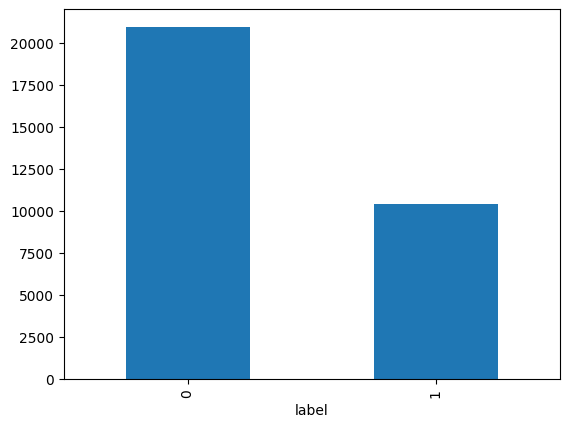

In [16]:
df['label'].value_counts().plot(kind='bar')

In [17]:
old_df = pd.read_csv(os.path.join(datapath, 'df_processed.csv'))[['berita', 'label']]
old_df.berita = old_df.berita.apply(lambda x : " ".join(eval(x)))
old_df.rename(columns = {
    'berita' : 'cleaned'
}, inplace = True)
old_df

,cleaned,label
0,gunung agung erupsi pertama kali november letu...,0
1,jakarta cnn indonesia menteri bumn erick thohi...,0
2,dosen fakultas dokter hewan ipb yusuf ridwan n...,0
3,jakarta anggota tni serda n serda da tusuk ora...,0
4,aku tembak jatuh pesawat ukraina iran tuai gel...,0
...,...,...
2193,hoaxvaksin kanker serviks anakanak sd menopaus...,0
2194,buah akun twitter nama akun gerilyapolitik mem...,0
2195,buah akun facebookmemposting video dia sebut b...,0
2196,buah akun facebook memposting status klaim web...,0


In [18]:
df = pd.concat([df, old_df], ignore_index = True)
df

,cleaned,label
0,Anies di Milad BKMT : Pengajian Menghasilkan I...,0
1,Edy Soal Pilgub Sumut : Kalau yang Maju Abal -...,0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0
...,...,...
33525,hoaxvaksin kanker serviks anakanak sd menopaus...,0
33526,buah akun twitter nama akun gerilyapolitik mem...,0
33527,buah akun facebookmemposting video dia sebut b...,0
33528,buah akun facebook memposting status klaim web...,0


In [15]:
df.cleaned.isnull().value_counts()

cleaned
False    31332
Name: count, dtype: int64

In [20]:
df.drop_duplicates(inplace = True)
df[df.duplicated()]

,cleaned,label


In [21]:
stop_factory = StopWordRemoverFactory()
more_stopword = ['dengan', 'ia','bahwa','oleh']
data = stop_factory.get_stop_words()+more_stopword
stopword = stop_factory.create_stop_word_remover()

Fact = StemmerFactory()
stemmer = Fact.create_stemmer()

def pipeline(text):
    text = re.sub(r'http\S+', '', text.lower())
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans("","",string.punctuation))
#     text = tokenizer(text)
    text = stemmer.stem(text)
    text = stopword.remove(text)
    return text

pipeline(df.cleaned[0]), df.cleaned[0]

('anies milad bkmt aji hasil ibu ibu tahu mantan gubernur dki jakarta anies baswedan hadir acara tasyakur milad tahun badan kontak majelis taklim bkmt istora senayan jakarta selasa pun puji eksistensi ibu ibu aji wujud hasil didik keluarga kata lama tahun usia bkmt jadi teladan hasil didik keluarga bkmt kata jadi bukti aji hasil ibu ibu lebih tahu bkmt jadi bukti aji hasil ibu ibu lebih tahu ibu ibu punya bekal didik anak anak buat rumah cermin nilai islam akhlak baik kata anies kutip unggah akun media sosial instagram milik unggah anies singgung soal bkmt tidak lepas sosok tuty alawiyah turut anies tuty bukan orang ustazah mampu pimpin ratus majelis taklim hingga jadi bkmt jangkau seluruh indonesia juga orang ibu hebat didik anak anak kami kenal prof dailami firdaus para saudara rupa pribadi pribadi hasil bidang tak juga guyub saling support tulis anies foto momen diri milad bkmt istora senayan itu tampak hadir jumlah tokoh politik jabat negara beberapa antara lihat foto unggah instag

In [17]:
df

,cleaned,label
0,Anies di Milad BKMT : Pengajian Menghasilkan I...,0
1,Edy Soal Pilgub Sumut : Kalau yang Maju Abal -...,0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0
...,...,...
31327,Raja Salman dari arab saudi membawa orang - or...,1
31328,"hehe , selalu bisa tersenyum melihat tingkah l...",1
31329,Pak Jokowi itu menjadi walikota periode pertam...,1
31330,"Hari ini , Rabu ( 23 / 09 / 2015 ) , nilai tuk...",1


In [24]:
df_true = df[df.label == 1]
df_false = df[df.label == 0]
df_false

,cleaned,label
0,Anies di Milad BKMT : Pengajian Menghasilkan I...,0
1,Edy Soal Pilgub Sumut : Kalau yang Maju Abal -...,0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0
...,...,...
20946,Nurul Arifin Ajak Perempuan Terjun ke Dunia Po...,0
20947,Kebangkitan Lawan Politik Jokowi . . . Pasanga...,0
20948,Ridwan Kamil Akui Pilkada DKI Berdampak pada S...,0
20949,Anies Belum Berpikir Apakah Akan Menjadi Anggo...,0


In [26]:
sampled_df_true = df_true.sample(1000)
sampled_df_false = df_false.sample(1000)
sampled_df = pd.concat([sampled_df_true, sampled_df_false])
sampled_df

,cleaned,label
25849,Close the Camps NARASI DALAM GAMBAR : Welcome ...,1
23816,Kepada Satanic Factcheker silahkan Terus Mengu...,1
29467,Narasi Pertama : Menolak Lupa ! . Sekelas Ment...,1
21757,"Oposisi Indonesia tidak berkualitas , semuanya...",1
24293,+ 6285394980681,1
...,...,...
15941,Jokowi Puji Heru Budi soal Sodetan Ciliwung ya...,0
7837,Demokrat Tepis Oposisi Memble : Kita Konsisten...,0
16507,Lika - liku Perjalanan Politik Megawati Soekar...,0
304,Yusril : Pembangunan Terlemah Pemerintahan Jok...,0


In [28]:
# df_cleaned = df.cleaned.apply(lambda x : pipeline(x))

In [35]:
# df_cleaned = pd.DataFrame({
#     'berita' : df_cleaned,
#     'label' : df.label
# })

# df_cleaned.to_excel(os.path.join(datapath, 'all_cleaned.xlsx'))

df_cleaned = pd.read_excel(os.path.join(datapath, 'all_cleaned.xlsx'))

In [43]:
X = df_cleaned[['berita']]
y = df_cleaned['label']
rus = RandomUnderSampler(random_state=1, replacement=True)# fit predictor and target variable
X_new, y_new = rus.fit_resample(X,y)
y_new.value_counts()

label
0    6486
1    6486
Name: count, dtype: int64

In [44]:
X_new

,berita
235,psi sebut banding pecat viani limardi tolak ad...
12172,tawar koalisi gerindra pks bilang cari teman l...
5192,dpr perintah kpu sepakat honor tugas tps naik ...
17294,megawati langkah politik bagai queen maker jel...
10955,dana milu capai rp triliun jokowi minta detail...
...,...
31327,raja salman arab saudi bawa orang orang sudah ...
31328,hehe selalu senyum lihat tingkah laku pak joko...
31329,pak jokowi jadi walikota periode pertama solo ...
31330,hari rabu nilai tukar rupiah puruk hingga semp...


In [45]:
y_new

235      0
12172    0
5192     0
17294    0
10955    0
        ..
31327    1
31328    1
31329    1
31330    1
31331    1
Name: label, Length: 12972, dtype: int64

In [46]:
df_new = X_new
df_new['label'] = y_new
df_new

,berita,label
235,psi sebut banding pecat viani limardi tolak ad...,0
12172,tawar koalisi gerindra pks bilang cari teman l...,0
5192,dpr perintah kpu sepakat honor tugas tps naik ...,0
17294,megawati langkah politik bagai queen maker jel...,0
10955,dana milu capai rp triliun jokowi minta detail...,0
...,...,...
31327,raja salman arab saudi bawa orang orang sudah ...,1
31328,hehe selalu senyum lihat tingkah laku pak joko...,1
31329,pak jokowi jadi walikota periode pertama solo ...,1
31330,hari rabu nilai tukar rupiah puruk hingga semp...,1


In [136]:
from tensorflow.keras.callbacks import Callback
            
class LossHistory(Callback):
    def __init__(self):
        super(Callback, self).__init__()
        self.losses = []
        self.val_losses = []

    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
#         print(self.losses, self.val_losses)

In [ ]:
callback = LossHistory()

In [ ]:
df_train, df_test = train_test_split(df_new, test_size=0.4, random_state=42,
                                     stratify=df_new['label'])

df_val, df_test_real = train_test_split(df_test, test_size=0.5, random_state=42,
                                     stratify=df_test['label'])

model_name = 'indobenchmark/indobert-base-p1'
# model_name = 'bert-base-cased'

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

max_len = 70

X_train = tokenizer(
    text=df_train['berita'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val = tokenizer(
    text=df_val['berita'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test_real['berita'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = model(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

y = Dense(1, activation='sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

optimizer = Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = 'binary_crossentropy'
metric = 'accuracy'

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'][:100], 'attention_mask':X_train['attention_mask'][:100]},
    y = df_train['label'][:100],
    validation_data = ({'input_ids':X_val['input_ids'][:50], 'attention_mask':X_val['attention_mask'][:50]},
                        df_val['label'][:50]),
    epochs=1,
    batch_size=32,
    callbacks=[callback]
)

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


[2.018144130706787] [None]
2/4 [==============>...............] - ETA: 5:27 - loss: 1.4396 - accuracy: 0.5469

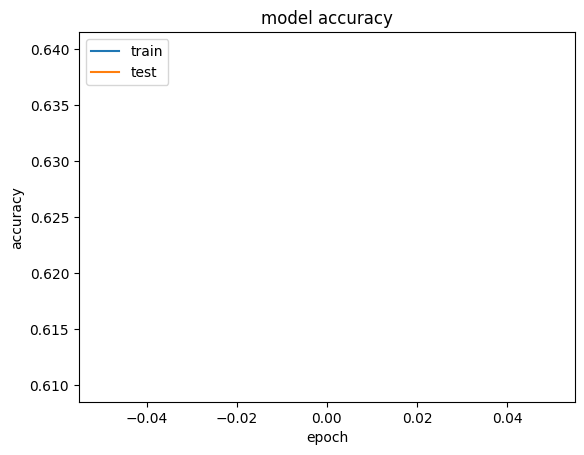

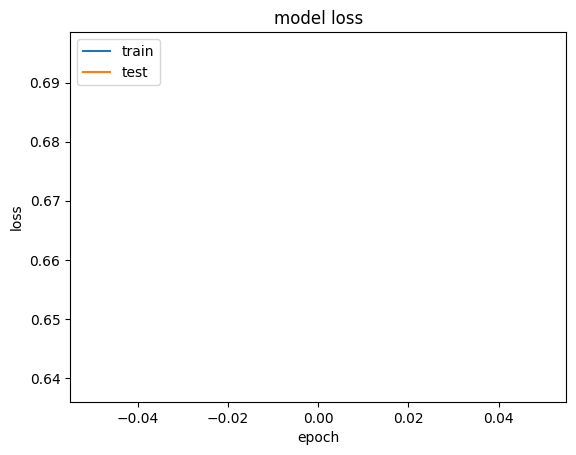

In [118]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 70)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 70)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_6 (TFBertMod  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 70, 76                                     

In [89]:
model.save('model_indobert.keras')

C:\Users\LENOVO\anaconda3\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [51]:
# df_train, df_test = train_test_split(df_new, test_size=0.3, random_state=42,
#                                      stratify=df_new['label'])

In [83]:
# X_train = tokenizer(
#     text=df_train['berita'].tolist(),
#     add_special_tokens=True,
#     max_length=max_len,
#     truncation=True,
#     padding=True,
#     return_tensors='tf',
#     return_token_type_ids=False,
#     return_attention_mask=True,
#     verbose=True
# )

# X_test = tokenizer(
#     text=df_test['berita'].tolist(),
#     add_special_tokens=True,
#     max_length=max_len,
#     truncation=True,
#     padding=True,
#     return_tensors='tf',
#     return_token_type_ids=False,
#     return_attention_mask=True,
#     verbose=True
# )

In [126]:
# input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
# input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# # embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

# embeddings = model(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# out = Dense(128, activation='relu')(out)
# out = tf.keras.layers.Dropout(0.1)(out)
# out = Dense(32, activation='relu')(out)

# y = Dense(1, activation='sigmoid')(out)

# model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
# model.layers[2].trainable = True

# optimizer = Adam(
#     learning_rate=5e-05, # HF recommendation
#     epsilon=1e-08,
#     clipnorm=1.0
# )

# loss = 'binary_crossentropy'
# metric = 'accuracy'

# model.compile(
#     optimizer=optimizer,
#     loss=loss,
#     metrics=metric
# )

# history = model.fit(
#     x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
#     y = to_categorical(df_train['label']),
#     validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
#                         to_categorical(df_test['label'])),
#     epochs=1,
#     batch_size=32
# )

In [78]:
# model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 70)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 70)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_3 (TFBertMod  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 70, 76                                     

In [94]:
X_test['input_ids']

<tf.Tensor: shape=(3892, 70), dtype=int32, numpy=
array([[    2,  1681, 10761, ...,  1578,   531,     3],
       [    2, 17368,   984, ...,   959,  1069,     3],
       [    2, 12444,   253, ...,  5115,  3074,     3],
       ...,
       [    2,  7121, 10639, ...,   899, 18006,     3],
       [    2,  1112, 30354, ...,  2727,   211,     3],
       [    2,   986,  6950, ...,     0,     0,     0]])>

In [97]:
predicted = model.predict({'input_ids': X_test['input_ids'][:2], 'attention_mask': X_test['attention_mask'][:2]})
y_predicted = np.argmax(predicted, axis=1)

1/1 [==============================] - 1s 1s/step


In [100]:
y_predicted, df_test['label'][:2]

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 18171    0
 19433    0
 Name: label, dtype: int64)

In [114]:
from sklearn.metrics import classification_report

predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = [1 if pred >= 0.5 else 0 for pred in predicted]
print(classification_report(df_test['label'], y_predicted))

KeyboardInterrupt: 

In [115]:
y_predicted = [1 if pred >= 0.5 else 0 for pred in predicted]
print(classification_report(df_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1946
           1       0.99      0.97      0.98      1946

    accuracy                           0.98      3892
   macro avg       0.98      0.98      0.98      3892
weighted avg       0.98      0.98      0.98      3892



In [103]:
sum(y_predicted), len(y_predicted)

(0, 3892)